In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pickle import dump

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv("/content/drive/My Drive/yachts_cleaned.csv")

In [ ]:
# Combine numerical data with text description and remove all but text and price columns
data['combined']="This is "+data['Title']+" yacht. It is located in "+data['Location']+". Tax status is "+data['Tax Status']+". It was built in "+data['Year'].astype(str)+". It has a length of "+data['Length_combined'].astype(str)+" meters. "+data['Description']
data = data[['Price_Adjusted','combined']]
# Drop missing values and extract descriptions
data=data.dropna()
data=data[data['Price_Adjusted']<200000]
data.rename(columns = {'Price_Adjusted':'Price'}, inplace = True)

In [ ]:
descriptions=data['combined'].tolist()

In [ ]:
# Download and define tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# encode descriptions using tokenizer
encoded_corpus = tokenizer(text=descriptions,
  add_special_tokens=True,
  padding='max_length',
  truncation='longest_first',
  max_length=512,
  return_attention_mask=True)

In [ ]:
# Define input ids and attention masks
input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

input_ids = np.array(input_ids)
attention_mask = np.array(attention_mask)
labels = data['Price'].to_numpy()

In [ ]:
# Split train and test inputs and labels
test_size = 0.1
seed = 42

train_valid_inputs, test_inputs, train_valid_labels, test_labels = \
            train_test_split(input_ids, labels, test_size=test_size,
                             random_state=seed)

train_inputs, valid_inputs, train_labels, valid_labels = \
            train_test_split(train_valid_inputs, train_valid_labels, test_size=test_size,
                             random_state=seed)

train_valid_masks, test_masks, _, _ = train_test_split(attention_mask,
                                        labels, test_size=test_size,
                                        random_state=seed)

train_masks, valid_masks, _, _ = train_test_split(train_valid_masks,
                                        train_valid_labels, test_size=test_size,
                                        random_state=seed)

In [ ]:
# Scale labels (prices)
price_scaler = StandardScaler()
price_scaler.fit(train_labels.reshape(-1, 1))

train_labels = price_scaler.transform(train_labels.reshape(-1, 1))
valid_labels = price_scaler.transform(valid_labels.reshape(-1, 1))

In [ ]:
# Define and create train and test dataloaders
batch_size = 16
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels)
    dataset = TensorDataset(input_tensor, mask_tensor,
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True)
    return dataloader

In [ ]:
train_dataloader = create_dataloaders(train_inputs, train_masks,
                                      train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks,
                                     test_labels, batch_size)
valid_dataloader = create_dataloaders(valid_inputs, valid_masks,
                                     valid_labels, batch_size)

In [ ]:
class BertRegressor(nn.Module):

    def __init__(self, drop_rate=0.2, freeze_bert=False):

        super(BertRegressor, self).__init__()
        D_in, D_out = 768, 1

        self.bert = \
                   BertModel.from_pretrained('bert-base-cased')
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))
    def forward(self, input_ids, attention_masks):

        outputs = self.bert(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs

model = BertRegressor(drop_rate=0.2)

In [ ]:
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Define the optimizer and the learning rate scheduler for our training process.
# We will use the Adam optimizer with a 5e-5 learning rate as was done in the official BERT paper.
optimizer = torch.optim.AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

# To define our scheduler, we must calculate the total number of training steps which is simply
# the number of training observations multiplied by the number of epochs.
# We will fine tune our model on 5 epochs.
epochs = 5
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                 num_warmup_steps=0, num_training_steps=total_steps)

# Loss function will be the Mean Squared Error loss, the most common loss function for regression problems.
loss_function = nn.MSELoss()

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def evaluate(model, loss_function, test_dataloader, device):
    # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
    model.eval()
    # Tracking variables
    test_loss, test_r2 = [], []
    # Unpack this training batch from our dataloader.
    for batch in test_dataloader:
        # As we unpack the batch, we'll also copy each tensor to the GPU using the `to` method.
        batch_inputs, batch_masks, batch_labels = \
                                 tuple(b.to(device) for b in batch)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            outputs = model(batch_inputs, batch_masks)
        loss = loss_function(outputs, batch_labels)
        test_loss.append(loss.item())
        r2 = r2_score(outputs, batch_labels)
        test_r2.append(r2.item())
    return test_loss, test_r2

def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
def train(model, optimizer, scheduler, loss_function, epochs,
          train_dataloader, device, clip_value=2):

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    for epoch in range(epochs):
        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
        print('Training...')
        # Measure how long the training epoch takes
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_train_loss = 0
        best_loss = 1e10
        model.train()
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 10 == 0 and not step == 0:
              elapsed = format_time(time.time() - t0)
              print(' Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)

            loss = loss_function(outputs.squeeze(),
                             batch_labels.squeeze().float())
            total_train_loss += loss.item()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))
        print("")
        print("Running Validation...")

        t0 = time.time()

        # Evaluate data for one epoch
        valid_loss, valid_r2 = evaluate(model, loss_function, valid_dataloader, device)

        # Accumulate the validation loss.
        total_eval_loss = sum(valid_loss)

        # Report the final R2 for this validation run.
        avg_r2 = sum(valid_r2) / len(valid_dataloader)
        print("  Average R_squared: {:}".format(avg_r2))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(valid_dataloader)
        print("  Average Validation Loss: {0:.2f}".format(avg_val_loss))

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_r2,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    return model, training_stats

In [ ]:
# Helper function for formatting elapsed times as hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
model.to(device)

BertRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [ ]:
model, training_stats = train(model, optimizer, scheduler, loss_function, epochs,
              train_dataloader, device, clip_value=2)


======== Epoch 1 / 5 ========
Training...
 Batch    10 of    51. Elapsed: 0:00:17.
 Batch    20 of    51. Elapsed: 0:00:32.
 Batch    30 of    51. Elapsed: 0:00:48.
 Batch    40 of    51. Elapsed: 0:01:04.
 Batch    50 of    51. Elapsed: 0:01:19.

  Average training loss: 0.82
  Training epoch took: 0:01:19

Running Validation...
  Average R_squared: 0.2397658630801727
  Average Validation Loss: 0.77
  Validation took: 0:00:03

======== Epoch 2 / 5 ========
Training...
 Batch    10 of    51. Elapsed: 0:00:15.
 Batch    20 of    51. Elapsed: 0:00:30.
 Batch    30 of    51. Elapsed: 0:00:45.
 Batch    40 of    51. Elapsed: 0:01:01.
 Batch    50 of    51. Elapsed: 0:01:16.

  Average training loss: 0.55
  Training epoch took: 0:01:16

Running Validation...
  Average R_squared: 0.310932861373234
  Average Validation Loss: 0.70
  Validation took: 0:00:03

======== Epoch 3 / 5 ========
Training...
 Batch    10 of    51. Elapsed: 0:00:15.
 Batch    20 of    51. Elapsed: 0:00:30.
 Batch    30

In [ ]:
# Display floats with two decimal places.
pd.set_option("display.precision", 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.82,0.77,0.24,0:01:19,0:00:03
2,0.55,0.70,0.31,0:01:16,0:00:03
3,0.31,0.48,0.35,0:01:16,0:00:03
4,0.18,0.30,0.70,0:01:16,0:00:03
5,0.10,0.34,0.63,0:01:16,0:00:03


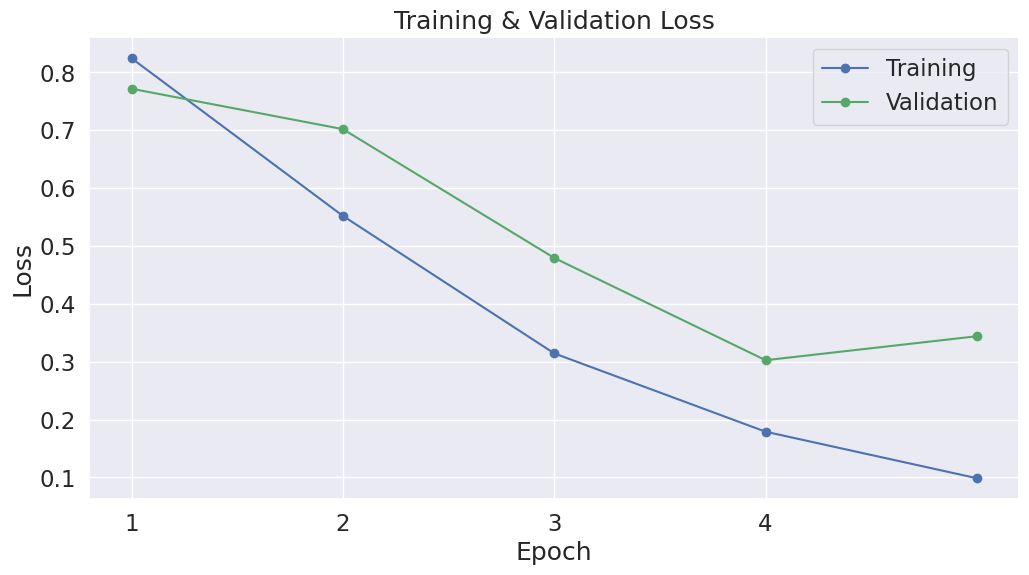

In [ ]:
#% matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
folder_path = f"/content/drive/My Drive/BERT_yacht"
tokenizer.save_pretrained(folder_path)
#model.save_pretrained(folder_path)

torch.save(model.state_dict(), folder_path + "/state_dict.json")
#torch.save(args, folder_path + 'training_args.bin')

# save the model
with open(folder_path + '/model.pkl', 'wb') as file:
  pickle.dump(model, file)
# save the scaler
# Open a file and use dump()
with open(folder_path + '/price_scaler.pkl', 'wb') as file:

    # A new file will be created
    pickle.dump(price_scaler, file)

In [ ]:
# Open the file in binary mode
with open('price_scaler.pkl', 'rb') as file:

    # Call load method to deserialze
    myvar = pickle.load(file)

    print(myvar)

StandardScaler()


Test of model

In [ ]:
model.load_state_dict(torch.load(folder_path + "/state_dict.json",map_location=torch.device('cpu')))

NameError: ignored

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks, _ = \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs,
                            batch_masks).view(1,-1).tolist()[0]
    return output

In [ ]:
y_pred_scaled = predict(model, test_dataloader, device)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score


In [ ]:
y_test = np.array(test_labels)
y_pred_scaled = np.array(y_pred_scaled)

y_pred = price_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mdae = median_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
# mdape = ((pd.Series(y_test) - pd.Series(y_pred.reshape(-1,1)))\
        # / pd.Series(y_test)).abs().median()
r_squared = r2_score(y_test, y_pred)

In [ ]:
print(mae)
print(mdae)
print(mse)
print(mape)
print(r_squared)

In [ ]:
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.scatter(y_test, y_pred)
plt.xlabel('y test')
plt.ylabel('y pred')
plt.show()

In [ ]:
results_df = pd.DataFrame(y_pred, columns=['y_pred'])
results_df['y_test']=pd.Series(y_test)
results_df['price_diff']=results_df['y_pred']-results_df['y_test']
results_df.sort_values('price_diff', axis=0, ascending=False, inplace=True)
print(results_df.head(10))

In [ ]:
data[data['Price']==19495]['combined']

In [ ]:
from os import walk

# folder path
dir_path = r'E:\\account\\'
path = f"/content/drive/My Drive/BERT_yacht"
#path = f"/content/drive/My Drive"

# list to store files name
res = []
for (dir_path, dir_names, file_names) in walk(path):
    res.extend(file_names)
print(res)